# Control moment gyroscope

**MODULES**

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
import scipy

from sympy.physics import mechanics
mechanics.init_vprinting()

# This is my own script (it is an interface to the pybullet simulator)
import ae353_cmg

**FEEDBACK & GAIN DERIVATION**

In [2]:
q1, q2, v1, v2, T = mechanics.dynamicsymbols('q1, q2, v1, v2, T')
V, J_1z, J_2x, J_2z, J_3x, J_3y, J_3z, m, r, g = 500, .5, .001, .001, .01, .01, .01, 1, 2, 9.81
a1 = -J_3y + 2*J_3z
a2 = 2*J_3y
a3 = -2*g*m*r
a4 = 2*J_1z + 2*J_2z + 2*m*r*r
a5 = 2*J_3z
a6 = (J_3y - J_3z)/(2*(J_2x + J_3x))
a7 = -1*J_3y / (J_2x + J_3x)
a8 = 1/(J_2x + J_3x)

m = sym.Matrix([q1, q2, v1 ,v2])
n = sym.Matrix([T])
m_dot = sym.Matrix([
    v1, 
    v2,
    (a1*sym.sin(2*q2)*v1*v2 + a2*sym.cos(q2)*v2*V + a3*sym.sin(q1))/(a4 + a5*sym.cos(q2)*sym.cos(q2)),
    a6*sym.sin(2*q2)*v1*v1 + a7*sym.cos(q2)*v1*V + a8*T
])
m_e = sym.Matrix([np.pi, 0, 0, 0]) #equilibrium points
n_e = sym.Matrix([0])
A_raw = m_dot.jacobian(m) #raw meaning that the equilibrium points have not been subbed in
B_raw = m_dot.jacobian(n)


A = A_raw.subs([(q1, m_e[0]), (q2, m_e[1]), (v1, m_e[2]), (v2, m_e[3])])
B = B_raw.subs(T, 0)

In [3]:
A_np = np.array(A).astype(float) #np meaning that the matrix has been converted to an array of floating point values
B_np = np.array(B).astype(float)
eigs = np.array([-2., -4., -6., -8.]) #desired eigenvalues (in our case, any 4 negative floats)

#Computes K-matrix that gives us desired eigenvalues
full_state_feedback = scipy.signal.place_poles(A_np, B_np, eigs)
K = full_state_feedback.gain_matrix
computed_poles = full_state_feedback.computed_poles #double checks that eigenvalues are possible, should be the same as eigs

In [4]:
computed_poles

array([-8., -6., -4., -2.])

In [5]:
K = K.flatten()
K

array([ 4.83296   , -0.97117554, -2.69125343,  0.22      ])

**CMG SIMULATOR**

Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

There are several optional arguments:

* `display` (`True` or `False`) is whether or not to show the simulation window;
* `damping` (a non-negative floating-point number, default `0.`) is the coefficient of viscous friction at each joint;
* `load_mass` (a non-negative floating-point number, default `1.`) is the mass of the sphere attached to the platform;
* `roll` (an angle in radians, default `np.pi / 2`) is the roll angle of the ground.

In [6]:
simulator = ae353_cmg.Simulator(
    display=True,
    damping=0.,
    load_mass=1.,
    roll=np.pi / 2,
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


Choose a default camera view (could also be `simulator.camera_topview()`).

In [7]:
simulator.camera_sideview()

Define a controller that maps sensor measurements to actuator commands. By default, it chooses to apply zero torque to the gimbal. Modify the `run` function to make the controller behave differently. This function will be called 100 times per second (i.e., at 100 Hz) by the simulator.

In [8]:
class Controller:
    def __init__(self):
        self.q1e = np.pi
        self.q2e = 0
        self.v1e = 0
        self.v2e = 0
    
    def reset(self):
        self.q1e = np.pi
        self.q2e = 0
        self.v1e = 0
        self.v2e = 0
    
    def run(
            self,
            t,
            platform_angle,
            platform_velocity,
            gimbal_angle,
            gimbal_velocity,
        ):
        
        pa = platform_angle%(2*np.pi)
        x = np.array([[pa - self.q1e], 
                      [gimbal_angle - self.q2e], 
                      [platform_velocity - self.v1e], 
                      [gimbal_velocity - self.v2e]])
        
        gimbal_torque = -K@x
      
        return gimbal_torque[0]

Create an instance of the controller.

In [9]:
controller = Controller()

Reset the simulator with given initial conditions. A separate PID controller, which you don't have to implement, will keep the rotor velocity constant.

In [13]:
simulator.reset(
    platform_angle=2.7,
    platform_velocity=0,
    gimbal_angle=0,
    gimbal_velocity=0,
    rotor_velocity=500.,
)

Reset the controller.

In [14]:
controller.reset()

Run the simulator.

In [15]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=20.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
)

**GENERATE DATA**

Get, show, and save a snapshot of the simulation after the last time step.

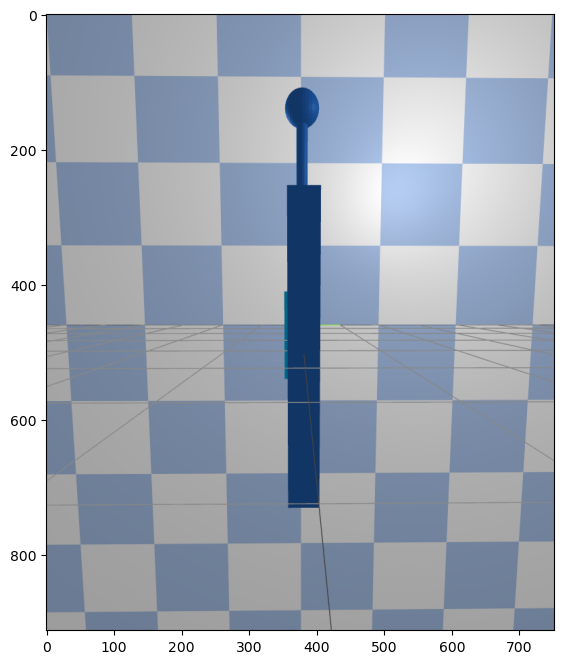

In [16]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot results.

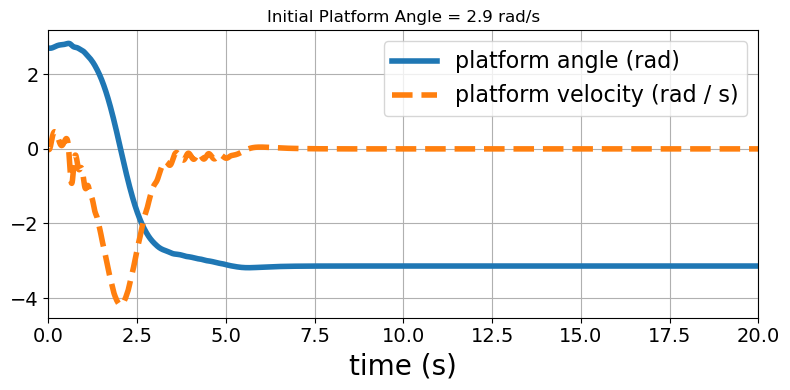

In [20]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_platform) = plt.subplots(1, 1, figsize=(8, 4), sharex=True)

# Plot platform angle and velocity
ax_platform.plot(
    data['t'], data['platform_angle'],
    label='platform angle (rad)', linewidth=4,
)
ax_platform.plot(
    data['t'], data['platform_velocity'],
    '--', label='platform velocity (rad / s)', linewidth=4,
)
ax_platform.grid()
ax_platform.legend(fontsize=16)
ax_platform.tick_params(labelsize=14)

# Plot gimbal angle and velocity
"""ax_gimbal.plot(
    data['t'], data['gimbal_angle'],
    label='gimbal angle (rad)', linewidth=4,
)
ax_gimbal.plot(
    data['t'], data['gimbal_velocity'],
    '--', label='gimbal velocity (rad / s)', linewidth=4,
)
ax_gimbal.grid()
ax_gimbal.legend(fontsize=16)
ax_gimbal.tick_params(labelsize=14)

# Plot rotor velocity
ax_rotor.plot(
    data['t'], data['rotor_velocity'],
    '--', label='rotor velocity (rad / s)', linewidth=4,
)
ax_rotor.grid()
ax_rotor.legend(fontsize=16)
ax_rotor.tick_params(labelsize=14)
ax_rotor.set_ylim(simulator.rotor_velocity - 10., simulator.rotor_velocity + 10.)

# Plot torques
ax_torque.plot(
    data['t'], data['gimbal_torque_command'],
    label='gimbal torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['gimbal_torque'],
    '--', label='gimbal torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['rotor_torque'],
    '--', label='rotor torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', label='max torque', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=16)
ax_torque.tick_params(labelsize=14)
"""
# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_platform.set_xlabel('time (s)', fontsize=20)
ax_platform.set_xlim([data['t'][0], data['t'][-1]])
plt.title("Initial Platform Angle = 2.7 rad/s") ###########################<<<----!!!!!!!
#ax_platform.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Make the arrangement of subplots look nice
fig.tight_layout()

Save the plots to a file.

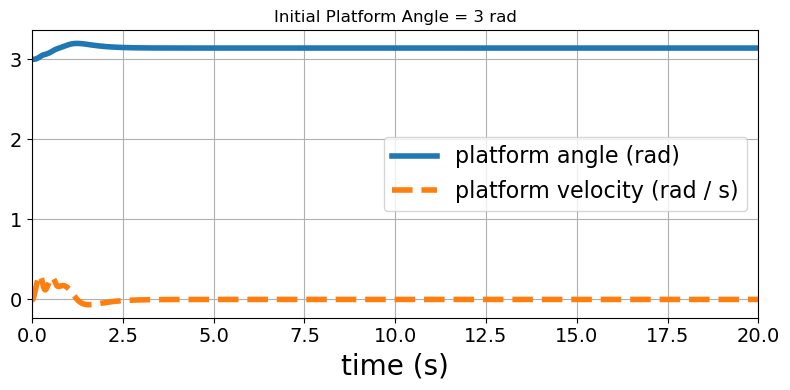

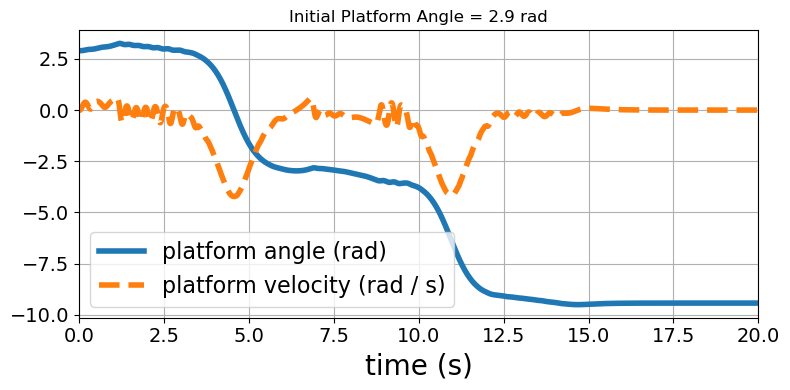

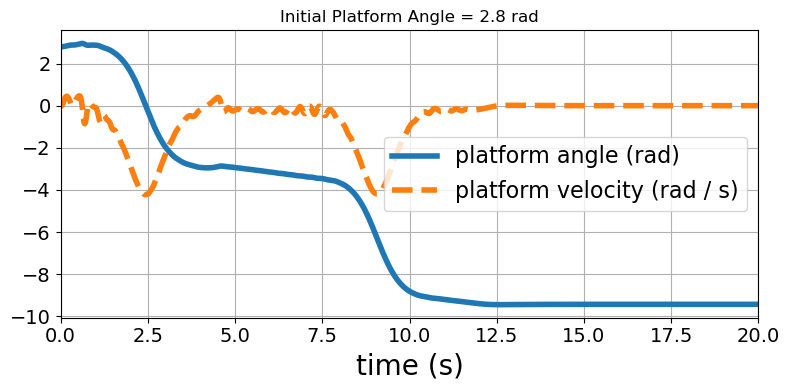

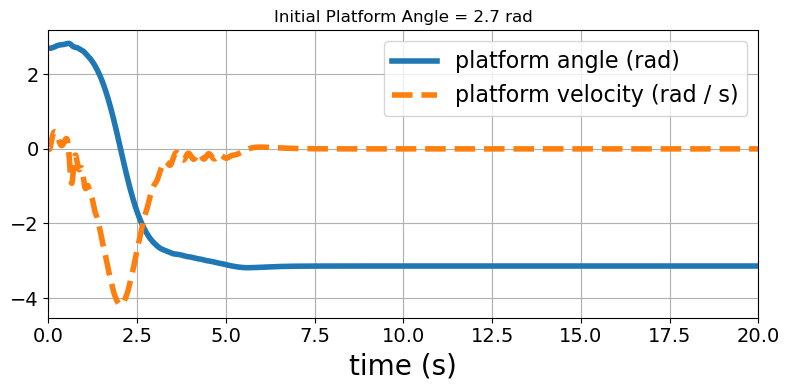

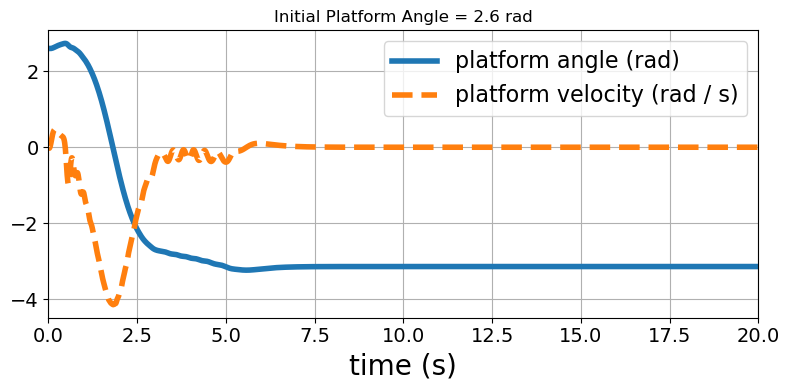

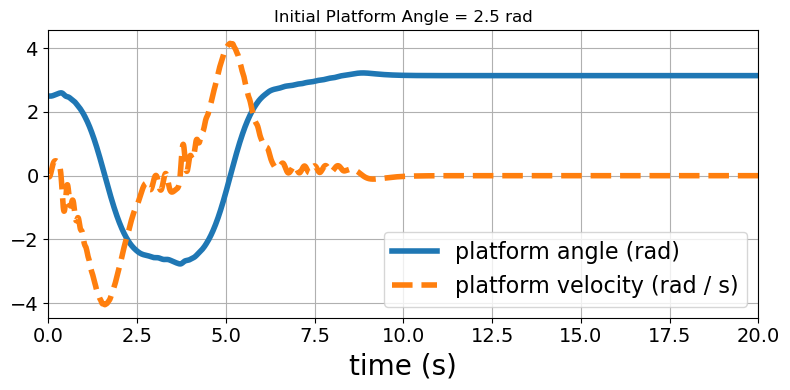

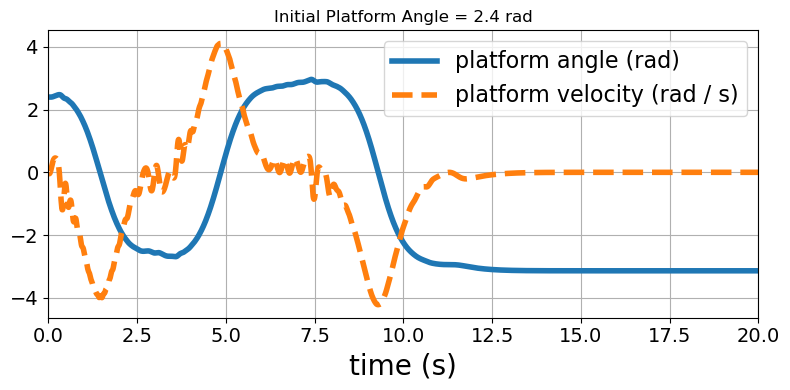

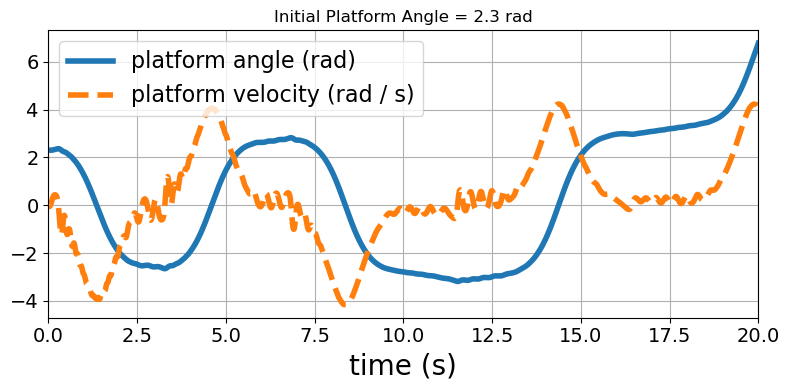

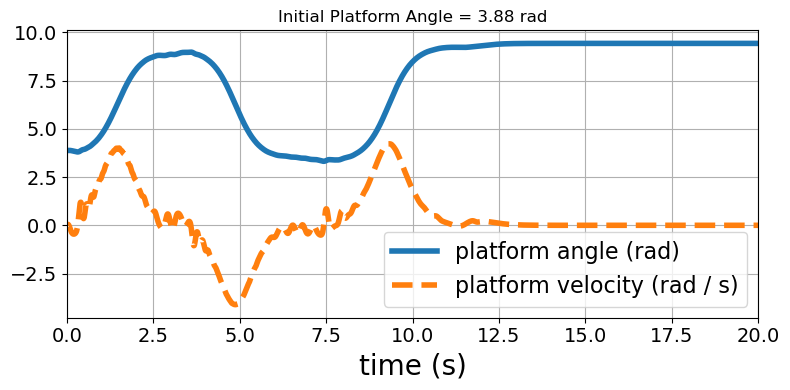

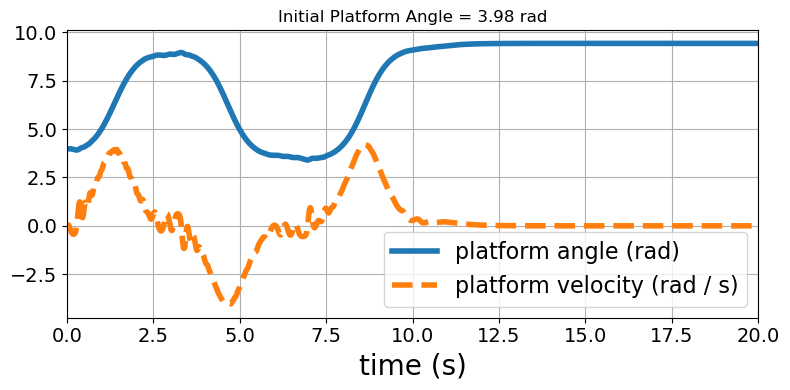

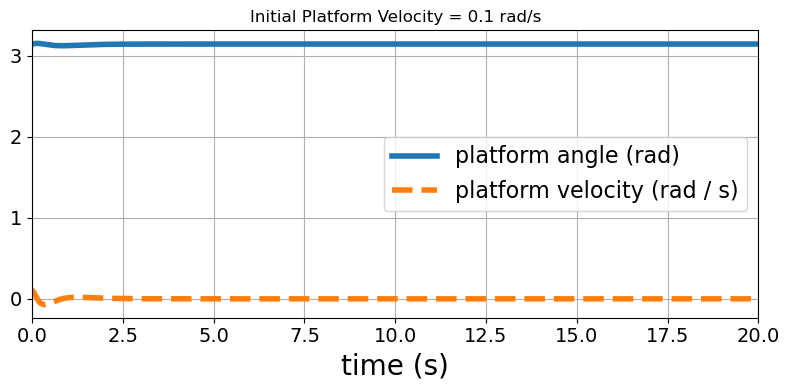

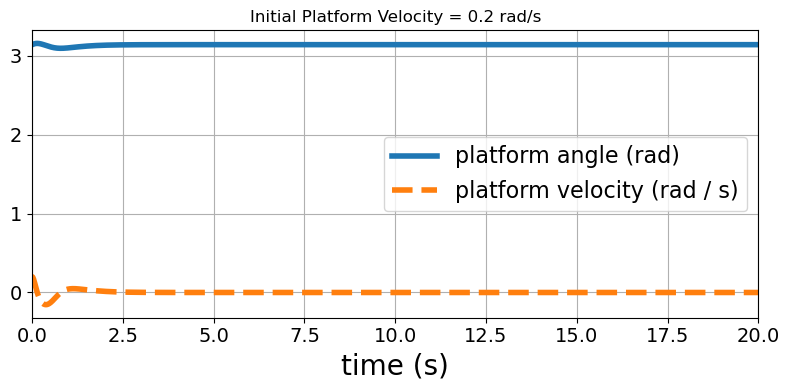

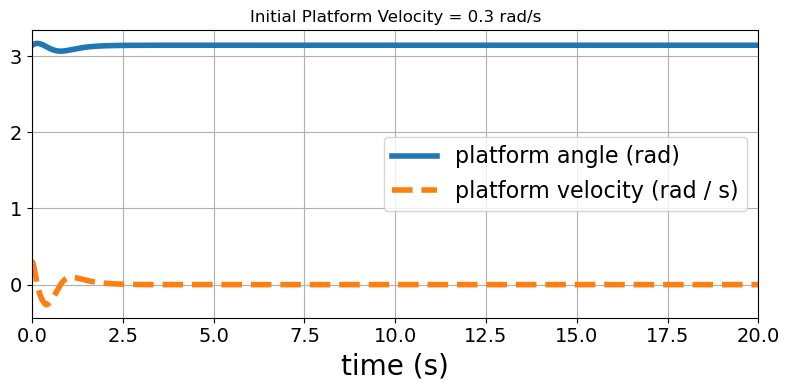

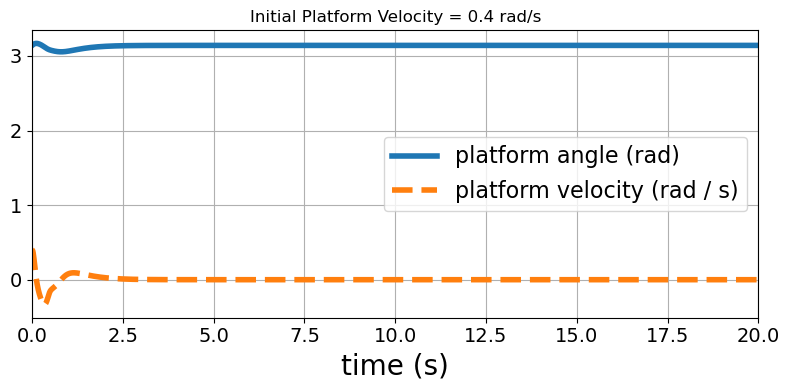

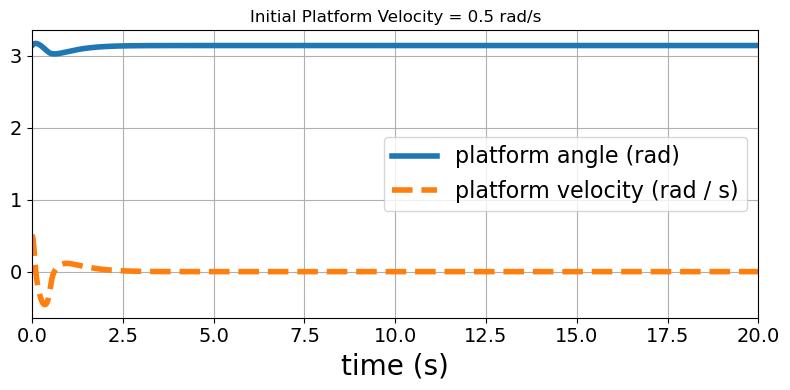

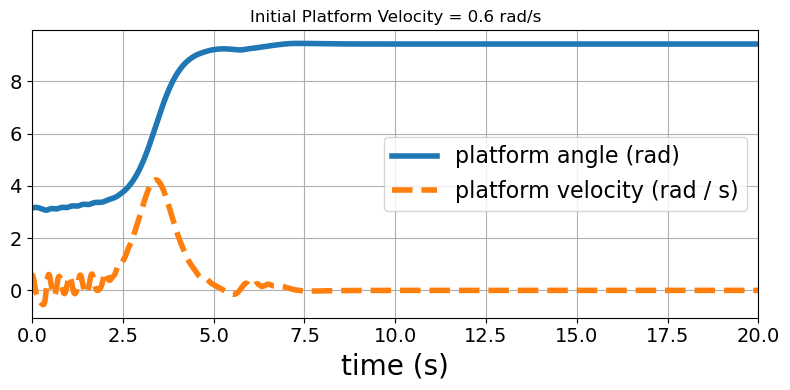

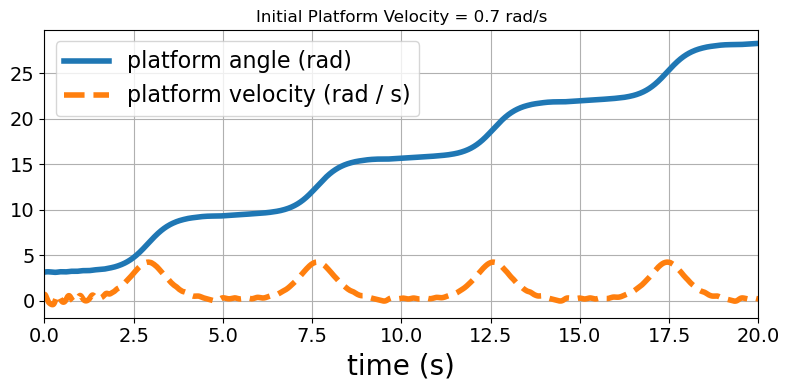

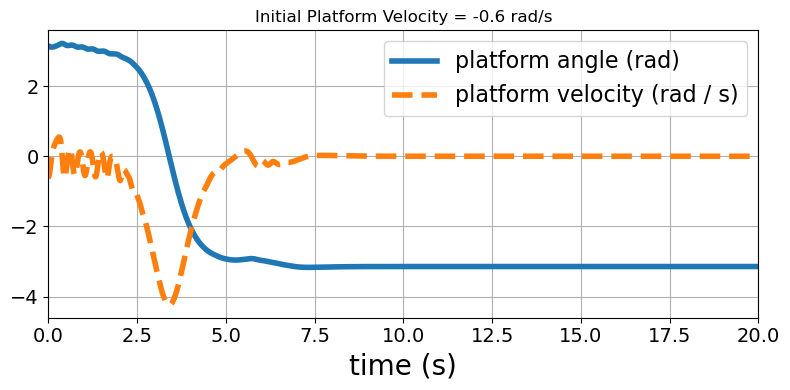

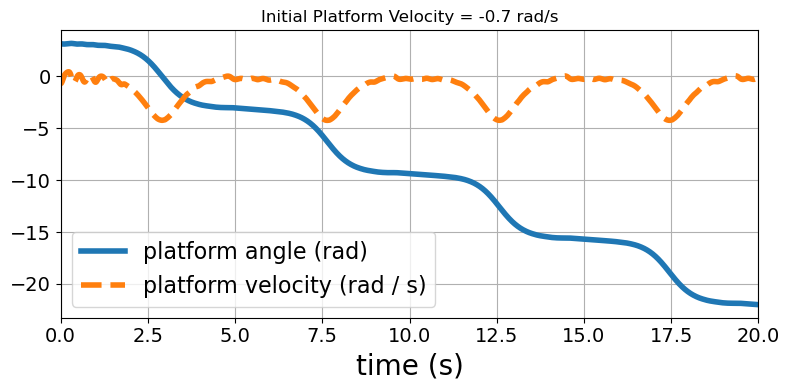

In [10]:
initial_angles = [3, 2.9, 2.8, 2.7, 2.6, 2.5, 2.4, 2.3, 3.88, 3.98]
initial_velocities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, -0.6, -0.7]

for i in initial_angles:
    simulator.reset(
        platform_angle=i,
        platform_velocity=0,
        gimbal_angle=0,
        gimbal_velocity=0,
        rotor_velocity=500.,
    )
    controller.reset()
    data = simulator.run(
        controller,           # <-- required (an instance of your Controller class)
        max_time=20.0,         # <-- optional (how long you want to run the simulation in seconds)
        data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
        video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
    )
    
    # Create a figure with three subplots, all of which share the same x-axis
    fig, (ax_platform) = plt.subplots(1, 1, figsize=(8, 4), sharex=True)

# Plot platform angle and velocity
    ax_platform.plot(
        data['t'], data['platform_angle'],
        label='platform angle (rad)', linewidth=4,
    )
    ax_platform.plot(
        data['t'], data['platform_velocity'],
        '--', label='platform velocity (rad / s)', linewidth=4,
    )
    ax_platform.grid()
    ax_platform.legend(fontsize=16)
    ax_platform.tick_params(labelsize=14)
    ax_platform.set_xlabel('time (s)', fontsize=20)
    ax_platform.set_xlim([data['t'][0], data['t'][-1]])
    plt.title("Initial Platform Angle = " + str(i) + " rad") ###########################<<<----!!!!!!!
    fig.tight_layout()
    
for j in initial_velocities:
    simulator.reset(
        platform_angle=np.pi,
        platform_velocity=j,
        gimbal_angle=0,
        gimbal_velocity=0,
        rotor_velocity=500.,
    )
    controller.reset()
    data = simulator.run(
        controller,           # <-- required (an instance of your Controller class)
        max_time=20.0,         # <-- optional (how long you want to run the simulation in seconds)
        data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
        video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
    )
    
    # Create a figure with three subplots, all of which share the same x-axis
    fig, (ax_platform) = plt.subplots(1, 1, figsize=(8, 4), sharex=True)

# Plot platform angle and velocity
    ax_platform.plot(
        data['t'], data['platform_angle'],
        label='platform angle (rad)', linewidth=4,
    )
    ax_platform.plot(
        data['t'], data['platform_velocity'],
        '--', label='platform velocity (rad / s)', linewidth=4,
    )
    ax_platform.grid()
    ax_platform.legend(fontsize=16)
    ax_platform.tick_params(labelsize=14)
    ax_platform.set_xlabel('time (s)', fontsize=20)
    ax_platform.set_xlim([data['t'][0], data['t'][-1]])
    plt.title("Initial Platform Velocity = " + str(j) + " rad/s") ###########################<<<----!!!!!!!
    fig.tight_layout()
    
    
    
    